# Insurance Claims- Fraud Detection

In [2]:
# Importing the libraries
import numpy as np 
import pandas as pd 
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import lightgbm as lgb

In [3]:
data = pd.read_csv("https://raw.githubusercontent.com/dsrscientist/Data-Science-ML-Capstone-Projects/master/Automobile_insurance_fraud.csv")

In [4]:
data.head()

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,capital-gains,capital-loss,incident_date,incident_type,collision_type,incident_severity,authorities_contacted,incident_state,incident_city,incident_location,incident_hour_of_the_day,number_of_vehicles_involved,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,_c39
0,328,48,521585,17-10-2014,OH,250/500,1000,1406.91,0,466132,MALE,MD,craft-repair,sleeping,husband,53300,0,25-01-2015,Single Vehicle Collision,Side Collision,Major Damage,Police,SC,Columbus,9935 4th Drive,5,1,YES,1,2,YES,71610,6510,13020,52080,Saab,92x,2004,Y,NaN
1,228,42,342868,27-06-2006,IN,250/500,2000,1197.22,5000000,468176,MALE,MD,machine-op-inspct,reading,other-relative,0,0,21-01-2015,Vehicle Theft,?,Minor Damage,Police,VA,Riverwood,6608 MLK Hwy,8,1,?,0,0,?,5070,780,780,3510,Mercedes,E400,2007,Y,NaN
2,134,29,687698,06-09-2000,OH,100/300,2000,1413.14,5000000,430632,FEMALE,PhD,sales,board-games,own-child,35100,0,22-02-2015,Multi-vehicle Collision,Rear Collision,Minor Damage,Police,NY,Columbus,7121 Francis Lane,7,3,NO,2,3,NO,34650,7700,3850,23100,Dodge,RAM,2007,N,NaN
3,256,41,227811,25-05-1990,IL,250/500,2000,1415.74,6000000,608117,FEMALE,PhD,armed-forces,board-games,unmarried,48900,-62400,10-01-2015,Single Vehicle Collision,Front Collision,Major Damage,Police,OH,Arlington,6956 Maple Drive,5,1,?,1,2,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y,NaN
4,228,44,367455,06-06-2014,IL,500/1000,1000,1583.91,6000000,610706,MALE,Associate,sales,board-games,unmarried,66000,-46000,17-02-2015,Vehicle Theft,?,Minor Damage,None,NY,Arlington,3041 3rd Ave,20,1,NO,0,1,NO,6500,1300,650,4550,Accura,RSX,2009,N,NaN


# Describing the data set

In [5]:
data.describe()

,months_as_customer,age,policy_number,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,capital-gains,capital-loss,incident_hour_of_the_day,number_of_vehicles_involved,bodily_injuries,witnesses,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_year,_c39
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,0.0
mean,203.954000,38.948000,546238.648000,1136.000000,1256.406150,1.101000e+06,501214.488000,25126.100000,-26793.700000,11.644000,1.83900,0.992000,1.487000,52761.94000,7433.420000,7399.570000,37928.950000,2005.103000,NaN
std,115.113174,9.140287,257063.005276,611.864673,244.167395,2.297407e+06,71701.610941,27872.187708,28104.096686,6.951373,1.01888,0.820127,1.111335,26401.53319,4880.951853,4824.726179,18886.252893,6.015861,NaN
min,0.000000,19.000000,100804.000000,500.000000,433.330000,-1.000000e+06,430104.000000,0.000000,-111100.000000,0.000000,1.00000,0.000000,0.000000,100.00000,0.000000,0.000000,70.000000,1995.000000,NaN
25%,115.750000,32.000000,335980.250000,500.000000,1089.607500,0.000000e+00,448404.500000,0.000000,-51500.000000,6.000000,1.00000,0.000000,1.000000,41812.50000,4295.000000,4445.000000,30292.500000,2000.000000,NaN
50%,199.500000,38.000000,533135.000000,1000.000000,1257.200000,0.000000e+00,466445.500000,0.000000,-23250.000000,12.000000,1.00000,1.000000,1.000000,58055.00000,6775.000000,6750.000000,42100.000000,2005.000000,NaN
75%,276.250000,44.000000,759099.750000,2000.000000,1415.695000,0.000000e+00,603251.000000,51025.000000,0.000000,17.000000,3.00000,2.000000,2.000000,70592.50000,11305.000000,10885.000000,50822.500000,2010.000000,NaN
max,479.000000,64.000000,999435.000000,2000.000000,2047.590000,1.000000e+07,620962.000000,100500.000000,0.000000,23.000000,4.00000,2.000000,3.000000,114920.00000,21450.000000,23670.000000,79560.000000,2015.000000,NaN


Dropping certain columns so that it won't affect dataset

In [6]:
# Dropping columns 
data.drop('_c39',axis=1,inplace=True)

In [7]:
#Checking missing values
# Function to calculate missing values by column
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [8]:
# Missing values statistics
missing_values = missing_values_table(data)
missing_values

Your selected dataframe has 39 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


# Label Encoding

In [9]:
#lets do Label enconding coding to make more features 

le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in data:
    if data[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(data[col].unique())) <= 2:
            # Train on the training data
            le.fit(data[col])
            # Transform both training and testing data
            data[col] = le.transform(data[col])
            
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

2 columns were label encoded.


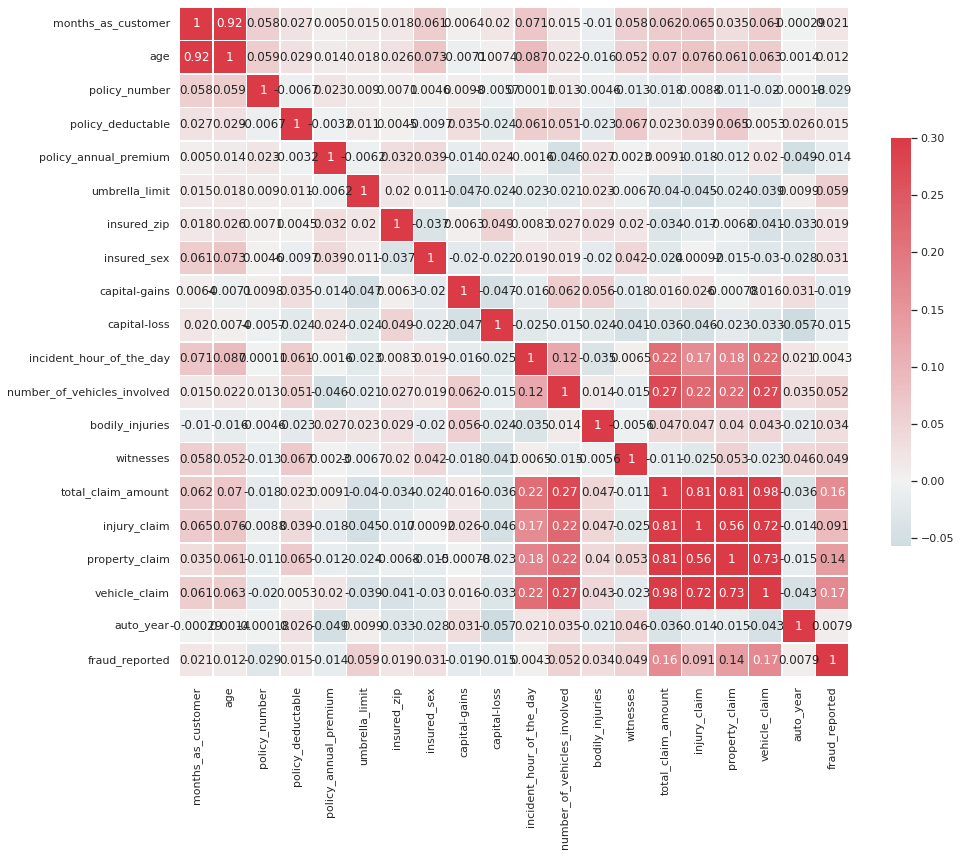

In [10]:
#data = pd.get_dummies(data)
#print('Training Features shape: ', data.shape)
sns.set(style="white")

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(data.corr(), cmap=cmap, vmax=.3, center=0,annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [11]:
colum_name =[]
unique_value=[]
# Iterate through the columns
for col in data:
    if data[col].dtype == 'object':
        # If 2 or fewer unique categories
        colum_name.append(str(col)) 
        unique_value.append(data[col].nunique())
table= pd.DataFrame()
table['Col_name'] = colum_name
table['Value']= unique_value
            
table=table.sort_values('Value',ascending=False)
table

,Col_name,Value
14,incident_location,1000
0,policy_bind_date,951
7,incident_date,60
18,auto_model,39
5,insured_hobbies,20
4,insured_occupation,14
17,auto_make,14
3,insured_education_level,7
12,incident_state,7
13,incident_city,7


In [12]:
# droping columns based on above result
data.drop(['incident_location','policy_bind_date','incident_date','auto_model','insured_occupation','policy_number'],axis=1,inplace=True)

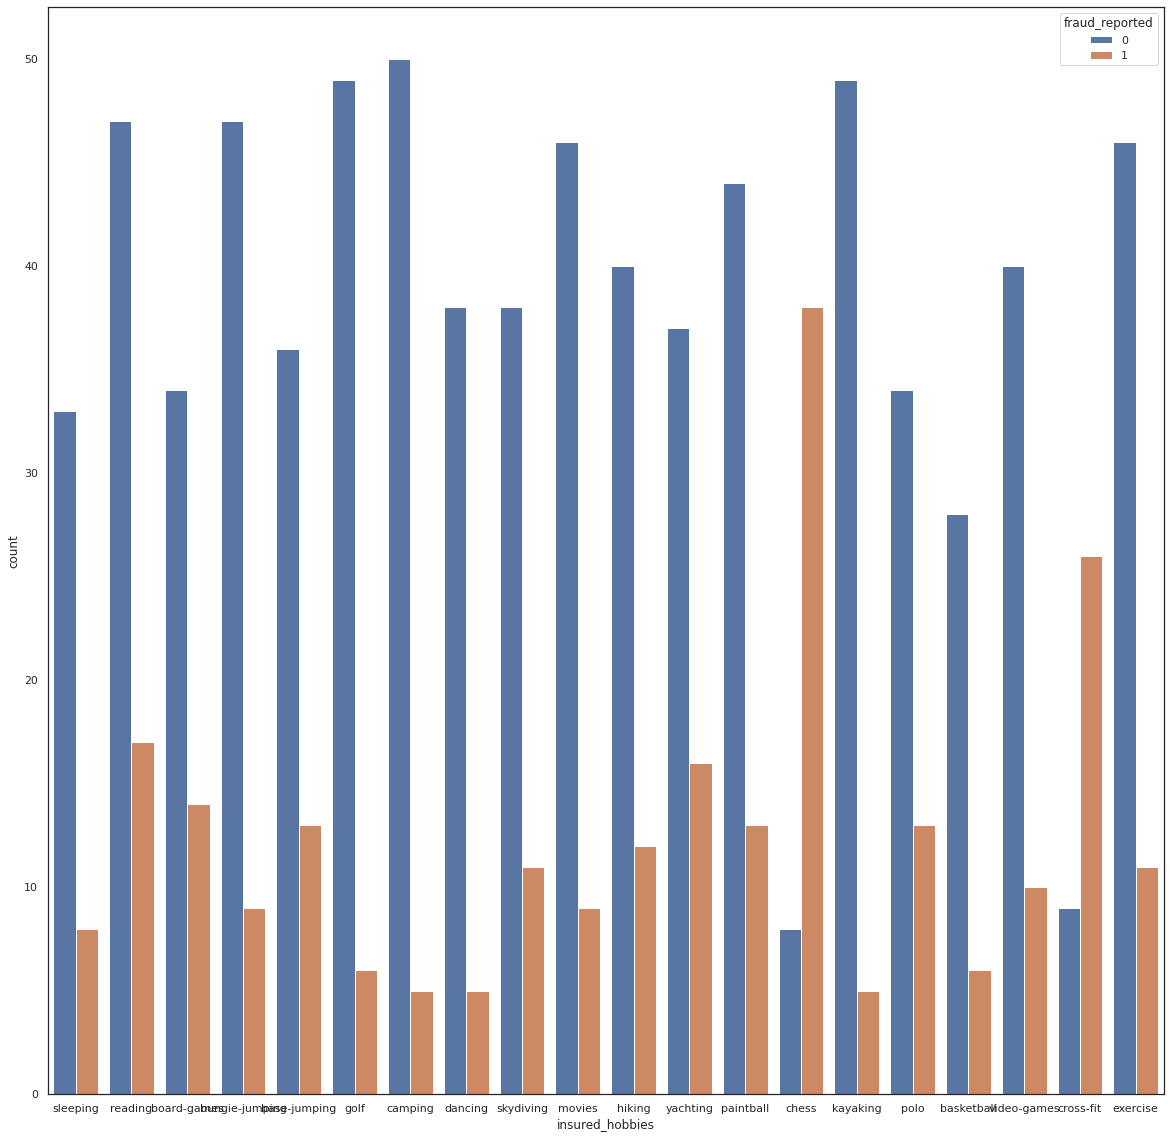

In [13]:
f, ax = plt.subplots(figsize=(20, 20))
sns.countplot(x='insured_hobbies',hue='fraud_reported',data=data)

## Create additional 'other' column if Insured hobbies are not chess and cross fit.

In [14]:
data['insured_hobbies']=data['insured_hobbies'].apply(lambda x :'Other' if x!='chess' and x!='cross-fit' else x)

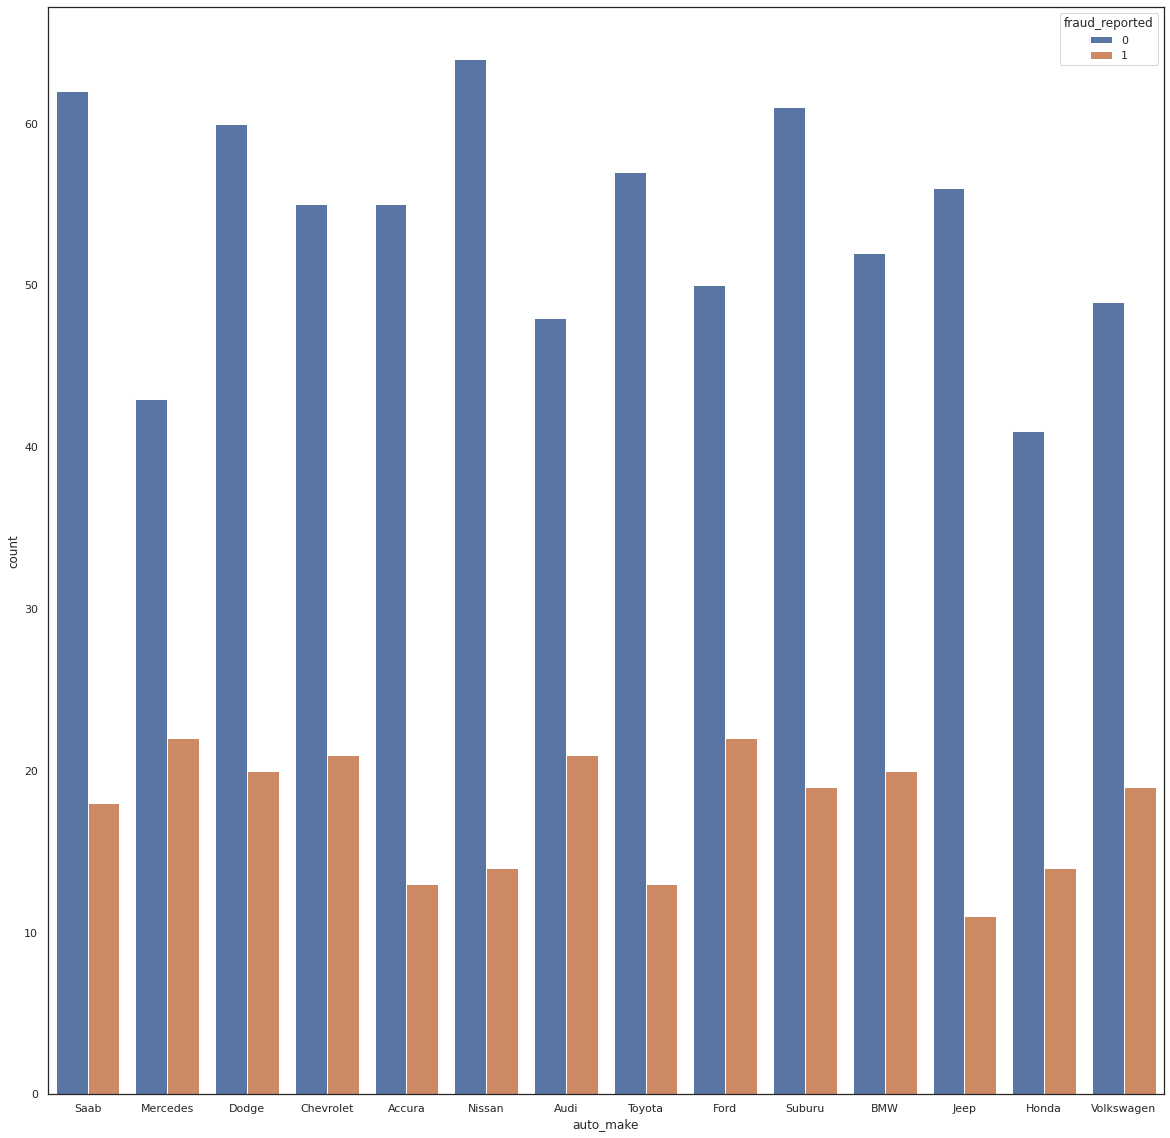

In [15]:
f, ax = plt.subplots(figsize=(20, 20))
sns.countplot(x='auto_make',hue='fraud_reported',data=data)

In [16]:
data['insured_hobbies'].unique()

array(['Other', 'chess', 'cross-fit'], dtype=object)

In [17]:
data = pd.get_dummies(data)
print('Training Features shape: ', data.shape)

Training Features shape:  (1000, 92)


## Lets check if Data is balanced data or not?

* Looking at below graph , the data looks imbalance.

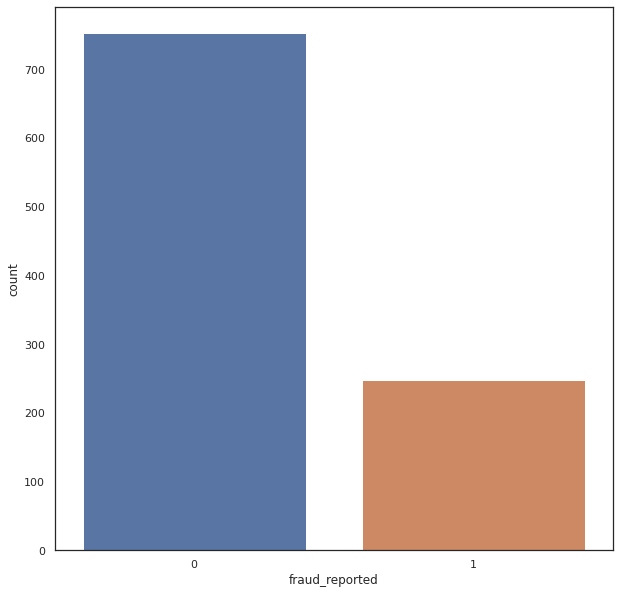

In [18]:
f, ax = plt.subplots(figsize=(10, 10))
sns.countplot(x='fraud_reported',data=data)

In [19]:
#f, ax = plt.subplots(figsize=(20, 20))
corr= data.corr()
y=data['fraud_reported']
X= data.drop('fraud_reported',axis=1)

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [22]:
from sklearn.metrics import f1_score

def lgb_f1_score(y_hat, data):
    y_true = data.get_label()
    y_hat = np.round(y_hat) # scikits f1 doesn't like probabilities
    return 'f1', f1_score(y_true, y_hat), True

In [23]:
def run_lgb(X_train, X_test, y_train, y_test, test_df):
    params = {
        "objective" : "binary",
       "n_estimators":1000,
       "reg_alpha" : 0.5,
       "reg_lambda":0.5,
       "n_jobs":-1,
       "colsample_bytree":.8,
       "min_child_weight":8,
       "subsample":0.8715623,
       "min_data_in_leaf":30,
       "nthread":4,
       "metric" : "f1",
       "num_leaves" : 10,
       "learning_rate" : 0.01,
       "verbosity" : -1,
       "seed": 60,
       "max_bin":60,
       'max_depth':3,
       'min_gain_to_split':.0222415,
       'scale_pos_weight':1.4,
        'bagging_fraction':0.8
    }
    
    lgtrain = lgb.Dataset(X_train, label=y_train)
    lgval = lgb.Dataset(X_test, label=y_test)
    evals_result = {}
    model = lgb.train(params, lgtrain, 10000, 
                      valid_sets=[lgtrain, lgval], 
                      early_stopping_rounds=100, 
                      verbose_eval=100, 
                      evals_result=evals_result,feval=lgb_f1_score)
    
    pred_test_y = model.predict(test_df, num_iteration=model.best_iteration)
    return pred_test_y, model, evals_result

In [24]:
pred_test, model, evals_result = run_lgb(X_train, X_test, y_train, y_test, X_test)
print("LightGBM Training Completed...")

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[100]	training's f1: 0.735484	valid_1's f1: 0.606897
[200]	training's f1: 0.740331	valid_1's f1: 0.745763
Early stopping, best iteration is:
[107]	training's f1: 0.75841	valid_1's f1: 0.645161
LightGBM Training Completed...


In [25]:
from sklearn.metrics import roc_auc_score

In [26]:
roc_auc_score(y_test,pred_test)

0.8661423981058683

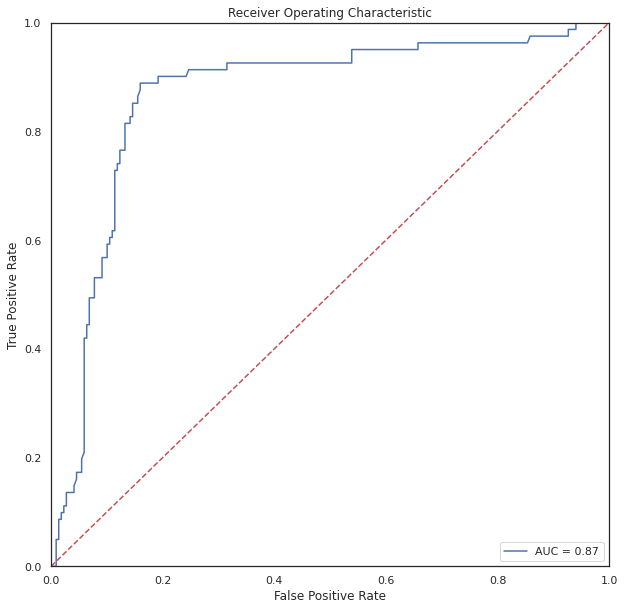

In [27]:
from sklearn import metrics
fpr, tpr, threshold = metrics.roc_curve(y_test, pred_test)
roc_auc = metrics.auc(fpr, tpr)
f, ax = plt.subplots(figsize=(10, 10))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Plot feature importances...


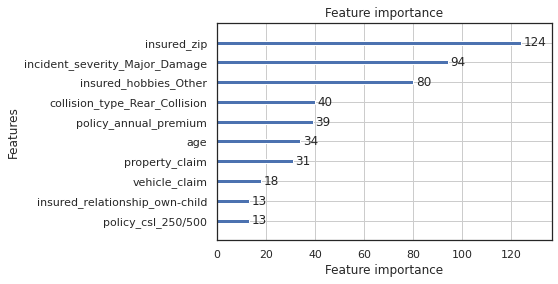

In [28]:
print('Plot feature importances...')
ax = lgb.plot_importance(model, max_num_features=10)
plt.show()